## this notebook is for our "hack" of ExoTransmit

**We're producing transit spectra for 2 different systems: Trappist-1 b around the Sun, and an "M-dwarf" transiting the same Sun. We then multiply out the stellar radius in the transit spectra for each, so we can then divide the planet spectra by the M-dwarf spectra.**

Note: all the spectra with ExoTransmit are calculated on the exact same wavelength grid, so I use the same wavelength variable throughout.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Can be found in kipping/Exo_Transmit/Spectra
# as of 19 Jan 2024
spectra_path = '/Users/coffey/Downloads/kipping/Exo_Transmit/Spectra'

### M dwarf: TRAPPIST-1
**T-P profile**                : 2500 K  
**EOS**                        : 1X_solar_gas  
**Planet g (m/s^2)**           : 1736  
**Planet R (m)**               : 8.2927e+7  
**Star R (m)**                 : 6.957e+8  
**Pressure of cloud top (Pa)** : 0.0  
**Rayleigh scattering factor** : 0.0

**Chemistry** : VO, TiO, H2O, Na, K, no collision induced, no scattering  

These parameters were obtained from Genaro's email, [Agol et al. 2021](https://iopscience.iop.org/article/10.3847/PSJ/abd022/pdf), and [Acuña et al. 2021](https://www.aanda.org/articles/aa/pdf/2021/03/aa39885-20.pdf).

In [3]:
mdwarf_spectrum  = np.loadtxt(f'{spectra_path}/transmission_trappist1.dat', skiprows = 2).T

wave         = mdwarf_spectrum[0][:2900] * 1e6 # microns
mdwarf_spec  = mdwarf_spectrum[1][:2900]

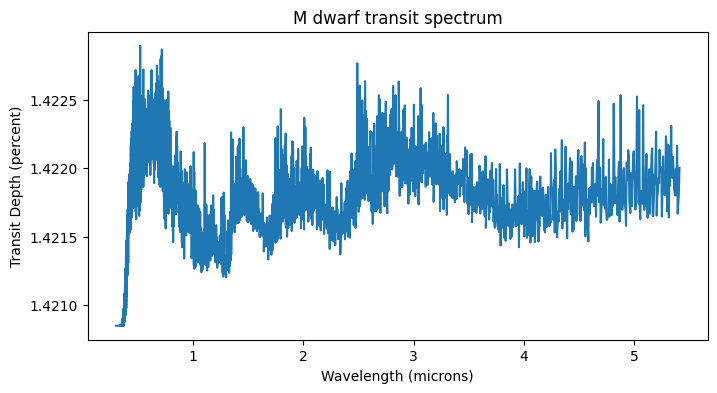

In [4]:
plt.figure(figsize = (8,4))
plt.title('M dwarf transit spectrum')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Transit Depth (percent)')

plt.plot(wave, mdwarf_spec)

plt.show()

### Trappist-1 b
Just producing a flat spectrum to measure effect from the star.

In [5]:
Rs   = 6.957e8  # Sun
Rt1b = 7.118e6  # Trappist-1 b
Rt1  = 8.2927e7 # Trappist-1

t1b_depth = (Rt1b / Rs)**2 * 100 # percent
t1b_spec = np.repeat(t1b_depth, len(mdwarf_spec))

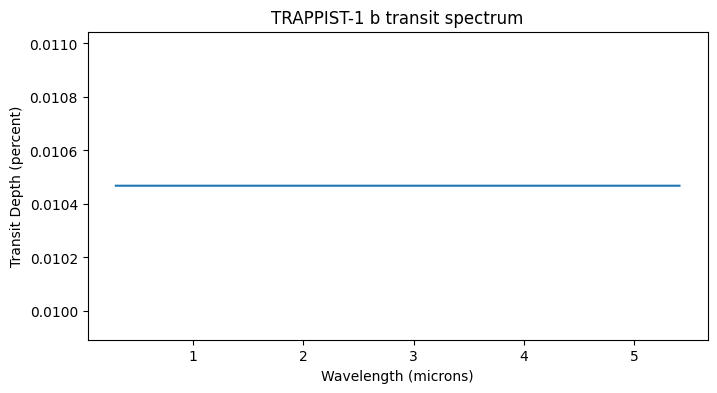

In [6]:
plt.figure(figsize = (8,4))
plt.title('TRAPPIST-1 b transit spectrum')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Transit Depth (percent)')

plt.plot(wave, t1b_spec)

plt.show()

## now we can multiply out the Sun's radius for both

First we take the square root of the transit depth $\delta = (R_p/R_s)^2$, then multiply by $R_s = 6.957e8 \ \text{m}$.

In [7]:
t1b_spec_noRs = np.sqrt(t1b_spec / 100) * Rs
mdwarf_spec_noRs  = np.sqrt(mdwarf_spec / 100) * Rs

Text(0.5, 0, 'Wavelength (microns)')

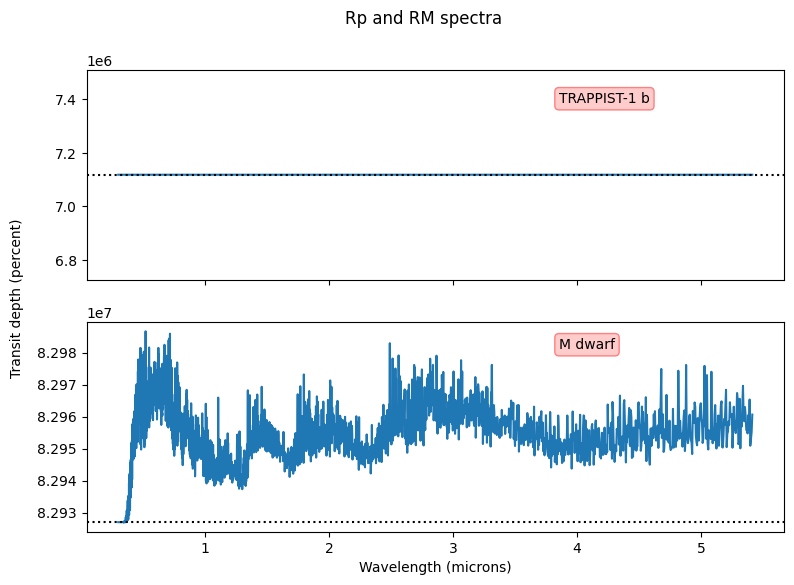

In [8]:
fig, axs = plt.subplots(2, 1, figsize = (9,6), sharex = True)

# Spectra
axs[0].plot(wave, t1b_spec_noRs, label = 'HAT-P-55 b')
axs[1].plot(wave, mdwarf_spec_noRs)
# Plotting their radii to confirm
axs[0].axhline(y = Rt1b, color = 'black', linestyle = 'dotted')
axs[1].axhline(y = Rt1, color = 'black', linestyle = 'dotted')

# Labels
fig.suptitle('Rp and RM spectra')
fig.text(0.04, 0.5, 'Transit depth (percent)', va='center', rotation='vertical')
fig.text(0.65, 0.825, 'TRAPPIST-1 b', bbox=dict(boxstyle='round',ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))
fig.text(0.65, 0.415, 'M dwarf', bbox=dict(boxstyle='round',ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))
axs[1].set_xlabel('Wavelength (microns)')

## combining the two spectra

Have $Rp$ and $Rs$ for our new $\delta = (R_p/R_s)^2$. Need to multiply by 100 to convert to percentage.

In [9]:
hacked_spec = (t1b_spec_noRs / mdwarf_spec_noRs)**2 * 100

Text(0.5, 0, 'Wavelength (microns)')

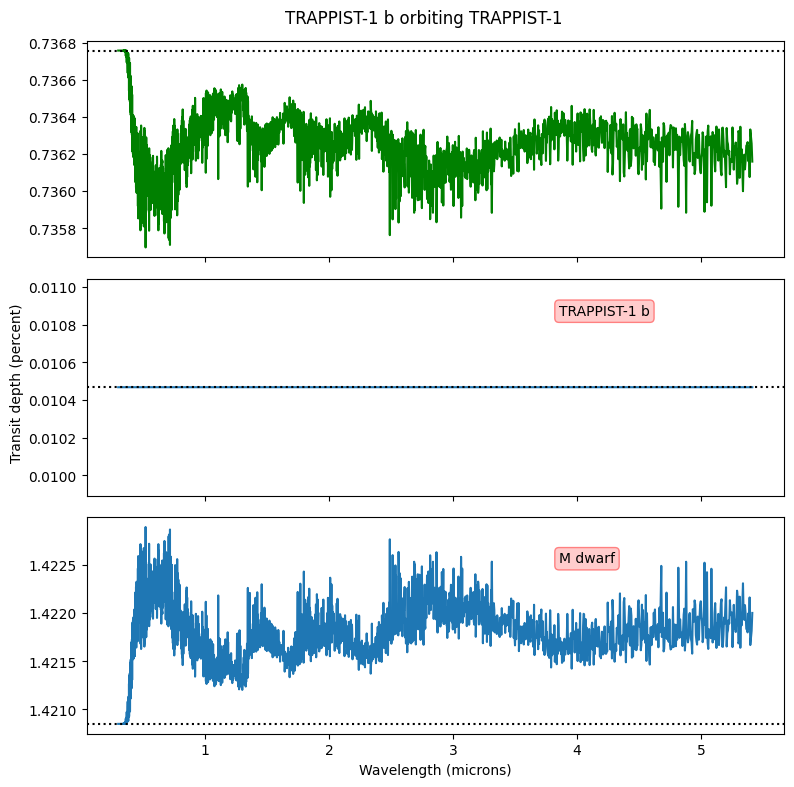

In [10]:
fig, axs = plt.subplots(3, 1, figsize = (9,9), sharex = True)
fig.subplots_adjust(hspace = 0.1)

# Spectra
axs[0].plot(wave, hacked_spec, color = 'green')
axs[1].plot(wave, t1b_spec)
axs[2].plot(wave, mdwarf_spec)

# Plotting transit depths to compare
axs[0].axhline(y = (Rt1b/Rt1)**2 * 100, color = 'black', linestyle = 'dotted')
axs[1].axhline(y = (Rt1b/Rs)**2 * 100, color = 'black', linestyle = 'dotted')
axs[2].axhline(y = (Rt1/Rs)**2 * 100, color = 'black', linestyle = 'dotted')

# Labels
fig.suptitle('TRAPPIST-1 b orbiting TRAPPIST-1', y = 0.915)
fig.text(0.04, 0.5, 'Transit depth (percent)', va='center', rotation='vertical')
fig.text(0.65, 0.575, 'TRAPPIST-1 b', bbox=dict(boxstyle='round',ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))
fig.text(0.65, 0.3, 'M dwarf', bbox=dict(boxstyle='round',ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))
axs[2].set_xlabel('Wavelength (microns)')

## for the final step we can smooth it to JWST prism resolution

In [11]:
def adap_smooth(wave, spec, R):
    """
    Smooths to a fixed spectral resolution according to:
    
    R = lamb / deltalamb
    
    Thus, the bin size changes for each wavelength.
    
    ================== Params ==================
    
    wave   : array or list of wavelengths
    spec   : array or list of transit depths
    R      : spectral resolution (JWST NIRSPEC: ~100 (prism), ~1000, or ~2700)
    
    ============================================
    
    """
    
    # Finding center of first bin
    # using equation lamb = 2R*np.min(lambs) / (2R-1)
    lamb0 = (2*R*wave[0]) / (2*R - 1)
    dellamb = lamb0 / R
    
    # binning wavelengths w/n +- dellamb/2 of lamb0
    bin_indices = np.where(np.logical_and(wave >= lamb0 - dellamb/2, wave < lamb0 + dellamb/2))
    
    # taking mean in bin
    mean0 = spec[bin_indices].mean()
    
    # creating list to store the smooth spectrum
    smooth_spec = [mean0]
    
    # repeating everything above for every bin
    for i in range(1,len(spec)):
        lamb = wave[i]
        dellamb = lamb / R
        bin_indices = np.where(np.logical_and(wave >= lamb - dellamb/2, wave < lamb + dellamb/2))
        mean = spec[bin_indices].mean()

        smooth_spec.append(mean)
    
    return smooth_spec

In [12]:
smooth_hacked_spec = adap_smooth(wave, hacked_spec, R = 100)
smooth_t1b_spec = adap_smooth(wave, t1b_spec, R = 100)
smooth_mdwarf_spec = adap_smooth(wave, mdwarf_spec, R = 100)

Text(0.5, 0, 'Wavelength (microns)')

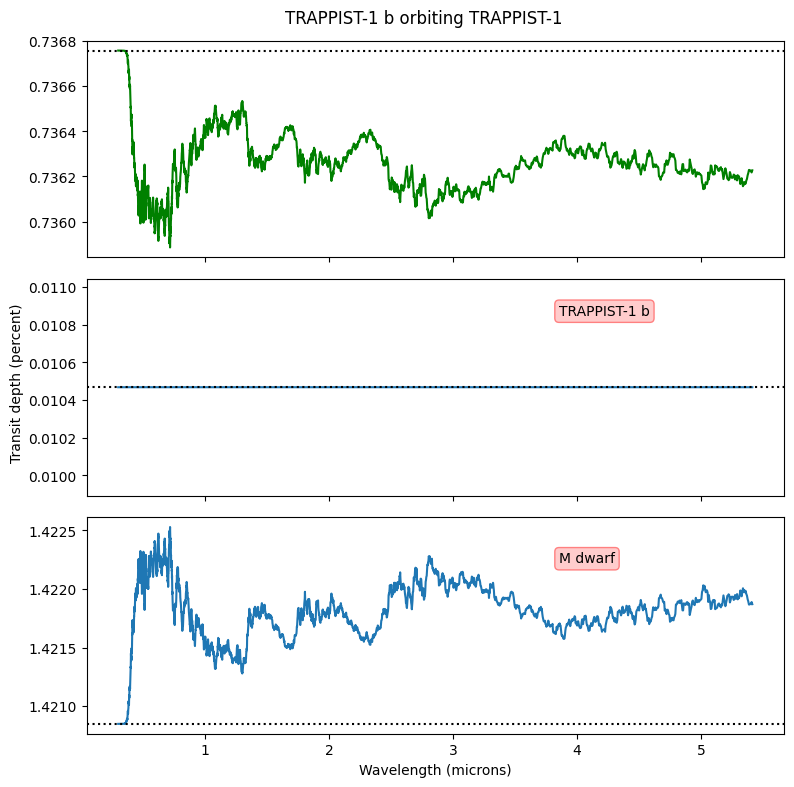

In [13]:
fig, axs = plt.subplots(3, 1, figsize = (9,9), sharex = True)
fig.subplots_adjust(hspace = 0.1)

# Spectra
axs[0].plot(wave, smooth_hacked_spec, color = 'green')
axs[1].plot(wave, smooth_t1b_spec)
axs[2].plot(wave, smooth_mdwarf_spec)

# Plotting transit depths to compare
axs[0].axhline(y = (Rt1b/Rt1)**2 * 100, color = 'black', linestyle = 'dotted')
axs[1].axhline(y = (Rt1b/Rs)**2 * 100, color = 'black', linestyle = 'dotted')
axs[2].axhline(y = (Rt1/Rs)**2 * 100, color = 'black', linestyle = 'dotted')

# Labels
fig.suptitle('TRAPPIST-1 b orbiting TRAPPIST-1', y = 0.915)
fig.text(0.04, 0.5, 'Transit depth (percent)', va='center', rotation='vertical')
fig.text(0.65, 0.575, 'TRAPPIST-1 b', bbox=dict(boxstyle='round',ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))
fig.text(0.65, 0.3, 'M dwarf', bbox=dict(boxstyle='round',ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))
axs[2].set_xlabel('Wavelength (microns)')

## Write it to a text file

In [14]:
# Saving the array in a text file
trappist_hacked_spectrum = np.column_stack((wave, smooth_hacked_spec))
np.savetxt("trappist_hacked_spectrum.txt", trappist_hacked_spectrum)